In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoModelForMaskedLM, AutoTokenizer, DefaultDataCollator

/vol/space/miniconda3/envs/gfm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = 'kuleshov-group/PlantCaduceus_l20'
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained(model_path, trust_remote_code=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [3]:
model.eval()

CaduceusForMaskedLM(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(8, 384)
        )
      )
      (layers): ModuleList(
        (0-19): 20 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=384, out_features=1536, bias=False)
                (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
                (act): SiLU()
                (x_proj): Linear(in_features=768, out_features=56, bias=False)
                (dt_proj): Linear(in_features=24, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=384, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=384, out_features=1536, bias=False)
                (conv1

In [4]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt

def plot_map_with_seq(matrix, dna_sequence,  plot_size=10, vmax=5, tick_label_fontsize=8):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()
    
def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [5]:
nuc_table = {"a" : 0, "c":1, "g":2, "t":3}

def mutate_sequence(seq):
    
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['a', 'c', 'g', 't']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func(seq):
    return tokenizer.encode_plus(seq, 
                                return_tensors='pt',
                                return_attention_mask=False, 
                                return_token_type_ids=False,
                                add_special_tokens=True)


def create_dataloader(dataset, batch_size=64):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(lambda x: tok_func(x['seq']), batched=False,  num_proc=4)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, 
                                              batch_size=batch_size, 
                                              num_workers=4, 
                                              shuffle=False, 
                                              collate_fn=data_collator)

    return data_loader

acgt_idxs = tokenizer.convert_tokens_to_ids(['a', 'c', 'g', 't'])

def model_inference(model, dataloader):
    output_array = []
    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device).squeeze(1)
        with torch.no_grad():
            outputs = model(input_ids=input_ids)
            logits = outputs.logits.cpu().to(torch.float32)
          #  print(f"Logits values: min {logits.min()}, max {logits.max()}, mean {logits.mean()}")
        output_probs = torch.nn.functional.softmax(logits, dim=-1)[:,:,acgt_idxs]
        output_array.append(output_probs)

    snp_reconstruct = torch.concat(output_array, axis=0)
    print(f"SNP Reconstruct values: min {snp_reconstruct.min()}, max {snp_reconstruct.max()}, mean {snp_reconstruct.mean()}")
    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)
     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]
   # print(f"Reference Prob values: min {reference_probs.min()}, max {reference_probs.max()}, mean {reference_probs.mean()}")
    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)
    #print(f"SNP Effect values: min {snp_effect.min()}, max {snp_effect.max()}, mean {snp_effect.mean()}")
    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0
    print(f"Dep Map values: min {dep_map.min()}, max {dep_map.max()}, mean {dep_map.mean()}")

    return dep_map


In [9]:
seq = "GTGTATTTCTAGAGGCGATTTGTCATTTCCCGAATAGGAATTTGAGTAAAAAAAAACACTCTGTTTTTTATTTCCACTAATATCAAATCGGCGAATATAGTTCCCACCATTCTTATCTCCTTGTCGTCACTCGGAATTTTTTAAATAATAGGATCGCTTTAATAATATAATCTCTATAATTTATAGTTCCTTTTCCAATATTGGCGTCTCCGTTGAAGCTTTCCACAAATCTCAAATTTGTTTGGAGACTCTCAAATGTATCCTTCTCTCGACGATGATTTCGTCTCTGATTTGTTTTGCTTCGATCAAAGGTTCGTCCTTTCGCACTCTTCTCTTCCTTCACCTTCCTCTGTTTTCTCTATCTCTTTCGATTCAGTTGTTTTATCGAATTTGATCCCTTTTTTCAATTGCAAAATCATATCTTTAATGTTCAATTCGATTTCTGTGAAAAGTGTTGTTGTTTTTTTCGCATTTCAGGGGGAAAGGTTGTGTCTTTTGATGATAATTTGACG".replace('U','T').lower()
len(seq)

512

In [7]:
dep_map = compute_dependency_map(seq)

Map (num_proc=4): 100%|██████████| 2049/2049 [00:00<00:00, 3147.44 examples/s]


SNP Reconstruct values: min 2.631824099808e-05, max 0.9990266561508179, mean 0.25
Dep Map values: min 0.0, max 9.382752418518066, mean 0.1245810810397785


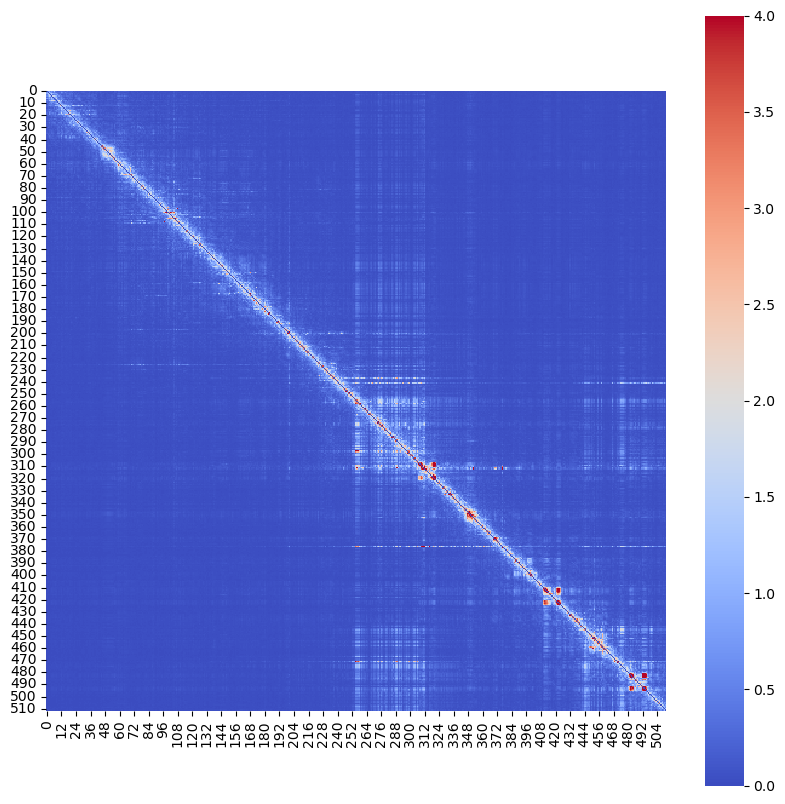

In [8]:
plot_map(dep_map, vmax=4)

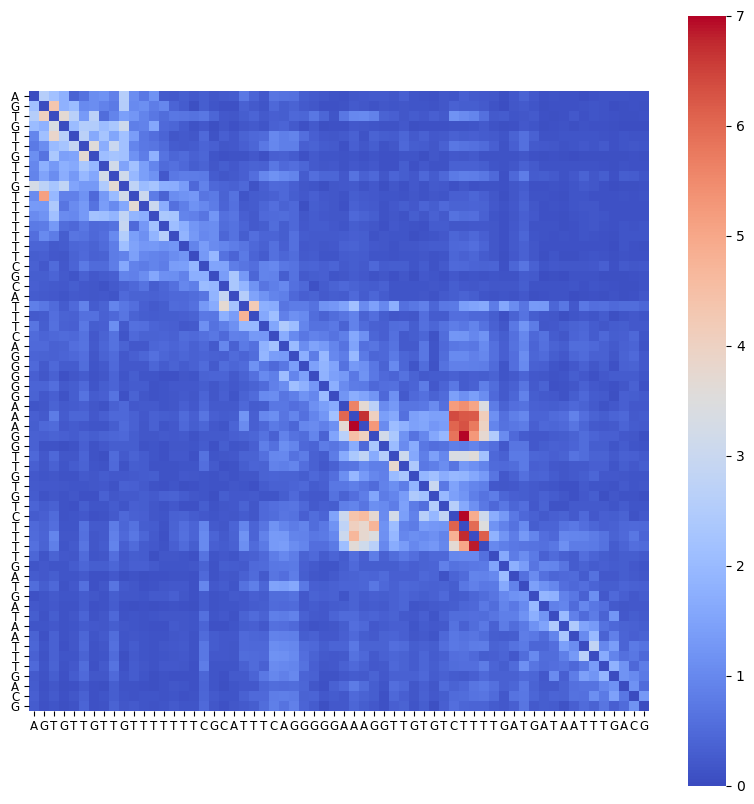

In [14]:
x,y = 450, 512
plot_map_with_seq(dep_map[x:y,x:y],  seq[x:y].upper(), vmax=7, tick_label_fontsize=8.5)

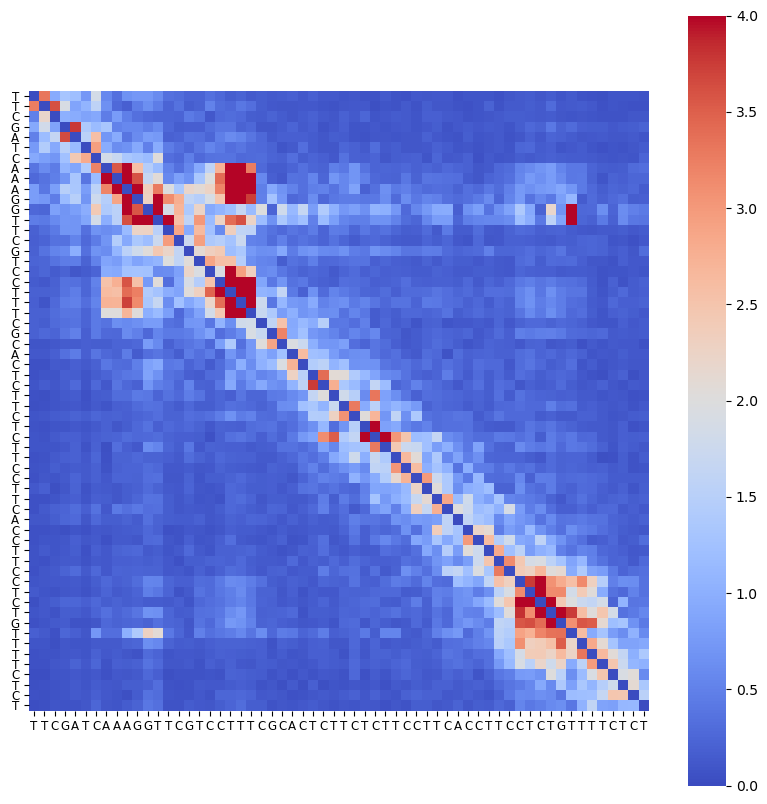

In [19]:
x,y = 300, 360
plot_map_with_seq(dep_map[x:y,x:y],  seq[x:y].upper(), vmax=4, tick_label_fontsize=8.5)

In [25]:
arab = "TATATTTATCATGAAAAGGTTAATTTGAATTCTATGGGTATTTTTAAAGATGGTAATTCATACAGACCACTGAAAATTAGAAATAAATACTCACATGCATACAAAAATCGGAAGGACGTGAGGAGAGGCCATTGTGATTGATTTGTATTTTGTAATATAAATTACATGTAAATTTTTCTTAATTAACTAGAATGAGGTATTTATTCTCATTTGGTAAAAATGGCTTCTCGACATTGTTTTTCACTCTCCTAAGTCATGGTTAACAAATTACTCAAAAACCGATTAGTCCGCCACCAAAAATCTTGAACCGAGAAACCAGATCTGAATGCGCAAATCTCCCGGTTTGATGGTTAACGAAGTTAGTCAAACAATCATTATGAACGTTAGATATAATAACACAAAATCCAAATTAAGGCTAATAATAGAGTGTGCATGGGAATTATCCGTAACCATGAGCCTTGTAGTACTCAAGATTCGAGAAAAGTTTCATCGTATAACACGTCCTTACCGTT".replace('U','T').lower()

In [31]:
dep_map_arab = compute_dependency_map(arab)

Map (num_proc=4): 100%|██████████| 2049/2049 [00:00<00:00, 2852.27 examples/s]


SNP Reconstruct values: min 0.0032365599181503057, max 0.9787192940711975, mean 0.25
Dep Map values: min 0.0, max 5.525150775909424, mean 0.10401546550362539


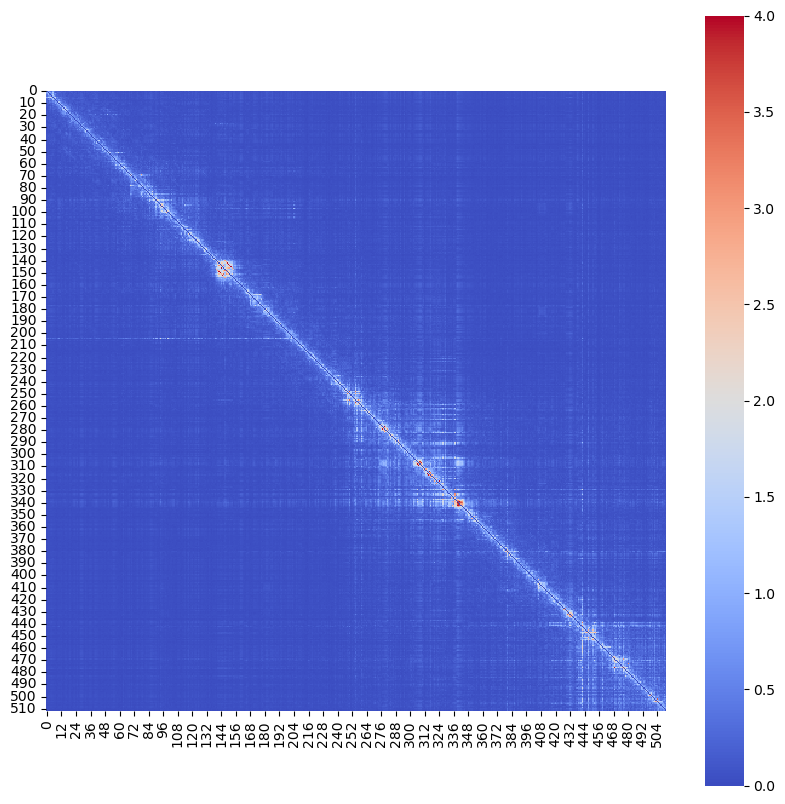

In [32]:
plot_map(dep_map_arab, vmax=4)

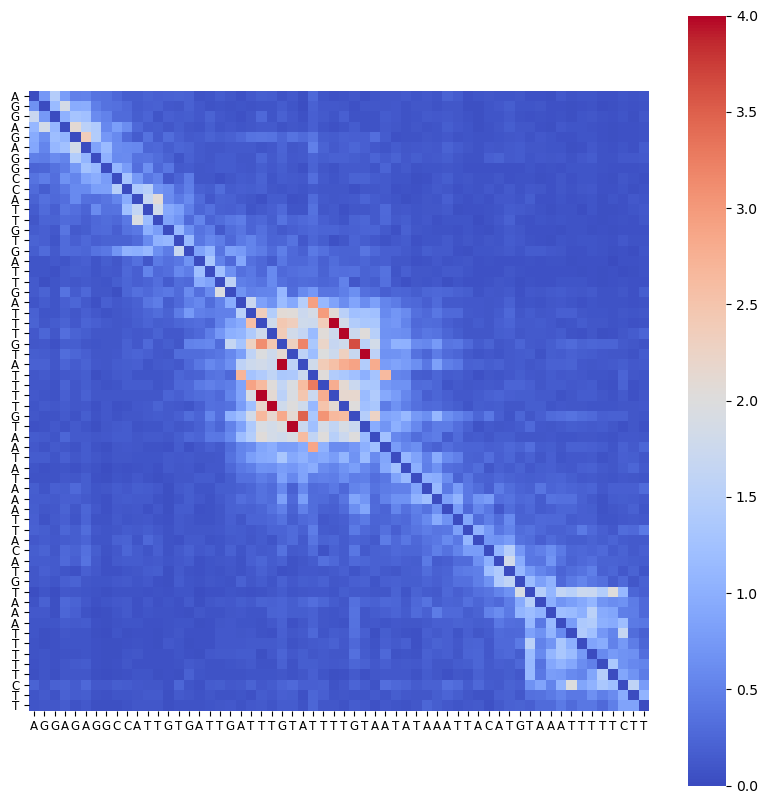

In [36]:
x,y = 120, 180
plot_map_with_seq(dep_map_arab[x:y,x:y],  arab[x:y].upper(), vmax=4, tick_label_fontsize=8.5)

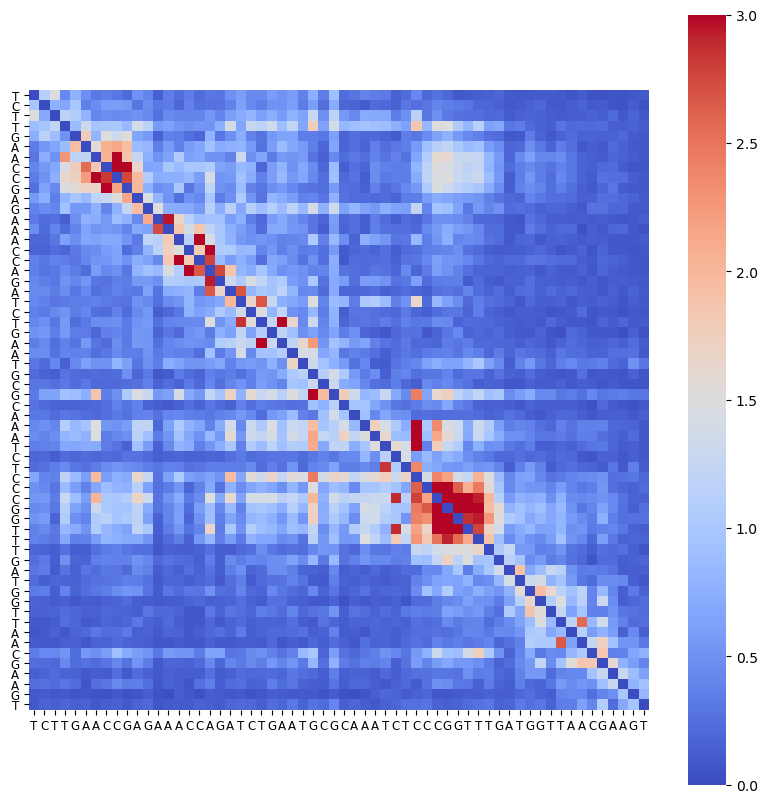

In [50]:
x,y = 300, 360
plot_map_with_seq(dep_map_arab[x:y,x:y],  arab[x:y].upper(), vmax=3, tick_label_fontsize=8.5)

In [ ]:
Arabidopsis_thaliana_tRNA_Asp_GTC_2_16 = "GTCGTTGTAGTATAGTGGTAAGTATTCCCGCCTGTCACGCGGGTGACCCGGGTTCGATCCCCGGCAACGGCG".replace("U","T").lower()

In [ ]:
dep_map_tRNA = compute_dependency_map(Arabidopsis_thaliana_tRNA_Asp_GTC_2_16)

Map (num_proc=4): 100%|██████████| 289/289 [00:00<00:00, 887.83 examples/s]


SNP Reconstruct values: min 2.986061645060545e-06, max 0.9999313354492188, mean 0.25
Dep Map values: min 0.0, max 10.990039825439453, mean 0.9113821511862535


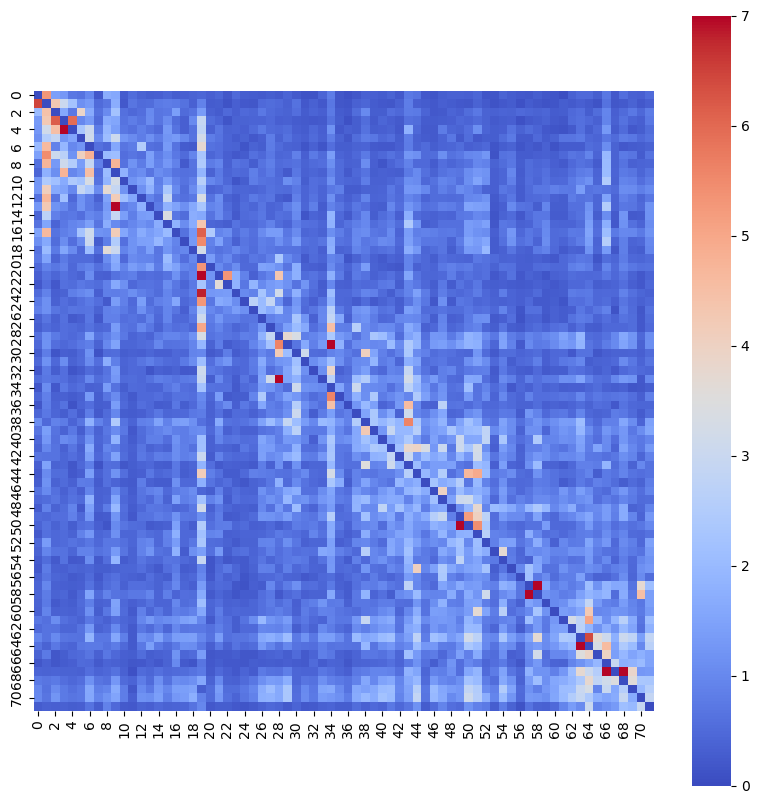

In [ ]:
plot_map(dep_map_tRNA, vmax=7)

Arabidopsis thaliana genes (TAIR10)
Upstream flank [512]
5‘ UTR

In [66]:
AT1G01040_1_5_UTR = "TAGTTAGAATAATTATTTTTATTTTTATTTTTATGGGAAAGAAGTTGCACGAGTCGGTCCACAGAATGACAGAACAAAAGCATTTTAGAAGTTTAGAACCAACCAATCACTATAGTTTTCCACTTGTCCGTATCTCATTGGTTCATCGAATATTAACTTACATGGAAACAGTAAAAAGCGTGGAATAAGTCGTAAAACTGAAATCTAAAAATGAAAAGATTTCGATTTCGATATAAATACTTAATCTTTATAAAATAATATCGAAATCTTTTCATTTTTAGTTTTCAGTTTTACACTTTTACTTGATAAATTTAATACATCTGTTAATTTTTTTTCTTCTAAAATTAACATATGATATCTATTCGGGAGATAACCCTAAGAAAACTGATAAAATAAATAAGTTACTTTTTACAAAGTCGAATAAATTATTTACCCTTCTGCTTTAATGGCAATTATCTTAATATTGCAAAAAAAAAAAGAGAGAAATATTACTACAAAACAGAAGCAAGCAAGTGGAAAACAGACCAGAAGAGAGAGGAAGACGAAGAGAGAAACAGAACAGAGTAGGGATCGATAGACCGTGGAATCTCAGAATCACAAACACTTTGCAAAAGGGTTTTCAATTCCTATTTATTTACAAAGAAATCATCAATAGTAGTGGTCTCTAGGGTTTTGCTTGCTCTTCTTCGTGACCCCTTTTTACCTGCAAACAACAACTTCAAAATTGGCGTGTTTCGTACGGTCTATCTAACCCTAATCTGTCACAAAACACTCTTCTTCTCTCACCCCTTTTTCTGGGTTTATTCAATTCTCGTGCTTTTGGTTCTGTTTTCTTCTCTGGGGATTTGGTTTTCTTGAGTGAGTTTTTCTCCTCTTTCTTATGTTCTTGATTTGATTATTATATAGAATT".lower()

In [62]:
dep_map_at1G = compute_dependency_map(AT1G01040_1_5_UTR)

Map (num_proc=4): 100%|██████████| 3641/3641 [00:01<00:00, 2681.50 examples/s]


SNP Reconstruct values: min 2.145686994481366e-05, max 0.9986086487770081, mean 0.25
Dep Map values: min 0.0, max 10.707965850830078, mean 0.07757454325254931


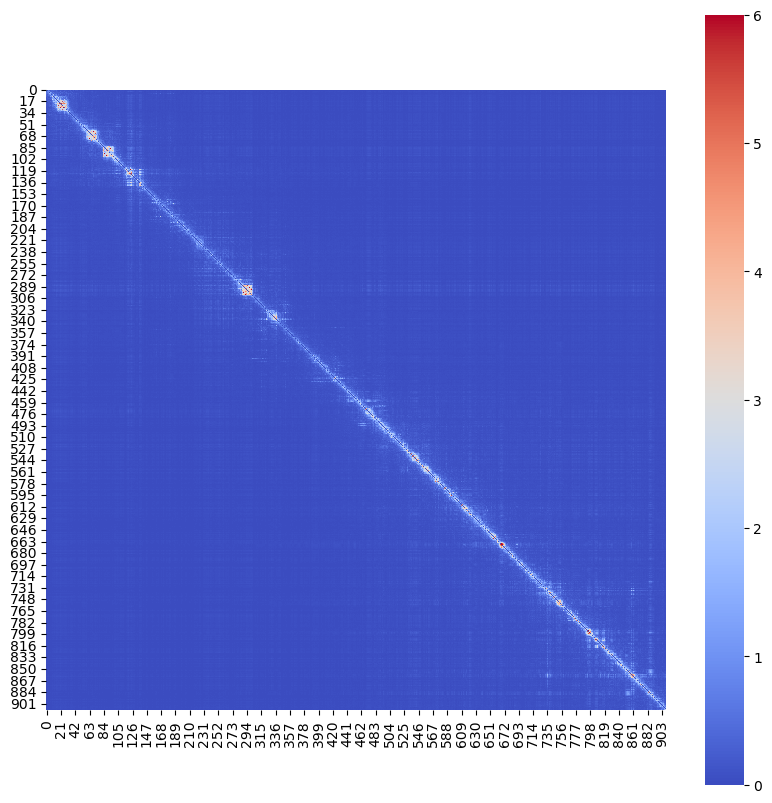

In [63]:
plot_map(dep_map_at1G, vmax=6)

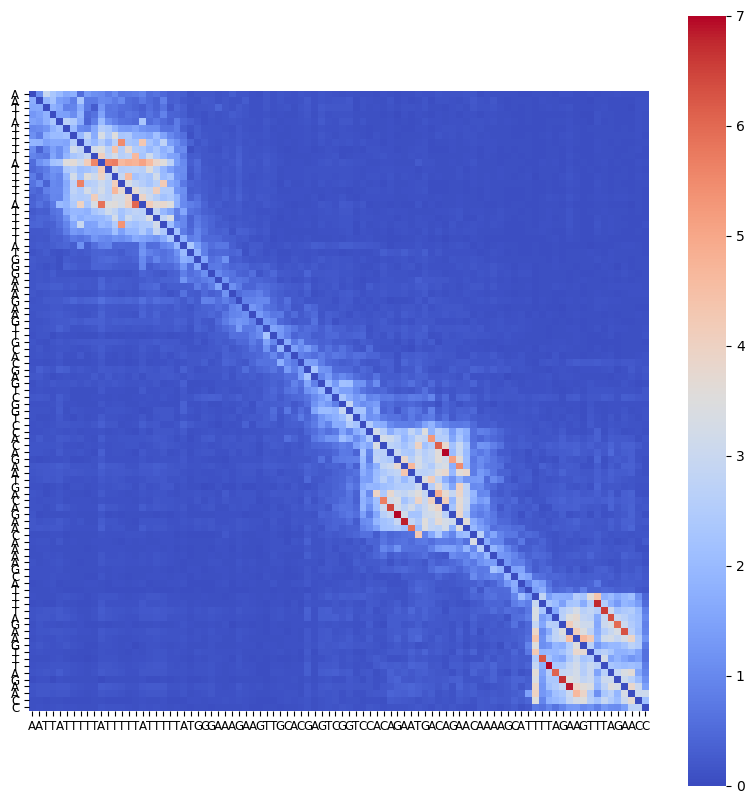

In [72]:
x,y = 10, 100
plot_map_with_seq(dep_map_at1G[x:y,x:y],  AT1G01040_1_5_UTR[x:y].upper(), vmax=7, tick_label_fontsize=8.5)

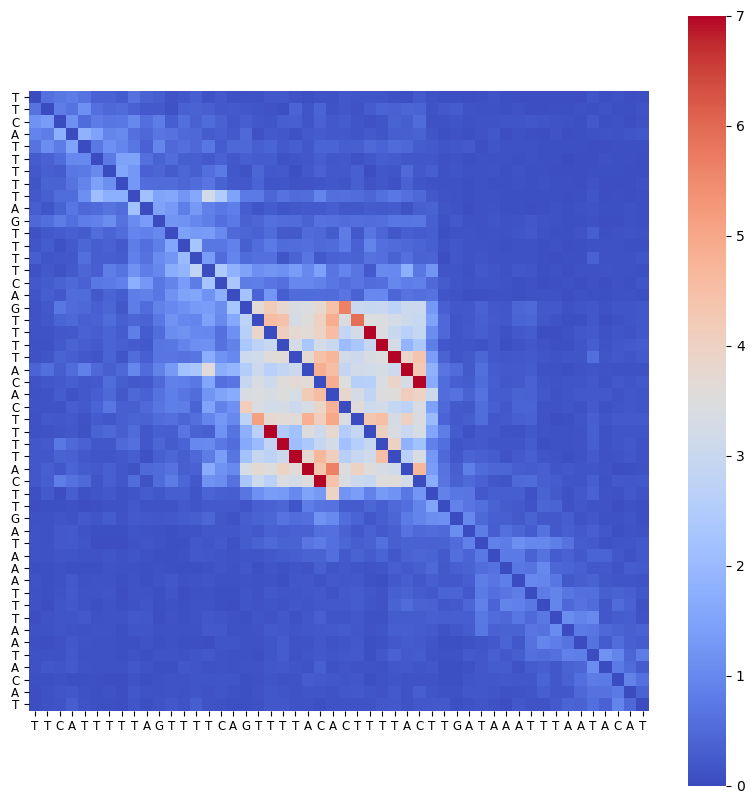

In [76]:
x,y = 270, 320
plot_map_with_seq(dep_map_at1G[x:y,x:y],  AT1G01040_1_5_UTR[x:y].upper(), vmax=7, tick_label_fontsize=8.5)